# ENERGY BURDEN ANALYSIS

# Introduction:

This analysis focuses on inferential analysis of energy burden in two different states (CO and GA) between 2013 - 2016. 

**Energy Burden = Total energy bill (avg cost of elec + avg cost of gas) / median income**



#### Overview:

This notebook is divided into 6 sections:

1. **Section 1: Understanding the data:** 
    - Exploratory data analysis (EDA)
    - Different questions that could be answered through this data 


2. **Section 2: Data Preprocessing and Feature Engineering:**
    - Data quality and consistency 
    - Handling missing values 
    - Identifying and eliminating data leakage / target leakage.


3. **Section 3: Data Analysis and Visualization**:
    - correlation matrix, 
    - univariate and multivariate correlations  
    - identifying outliers
    

4. **Section 4: Feature selection**:
    - Data normalization
    - Feature selection:
        - Correlation matrix: Using the Pearson's correlation coefficient 
        - Removing multicollinearity
        - p-value

5. **Section 5: Model Building**:
      - Create a baseline models - Linear Regression and Randon Forest
      - Regularization and hyperparameter tuning
      - Cross validation
      - Evaluation
      - Choosing best model and predicting on test data
      - Save model architectures to pickle file
    


6. **Section 6: Conclusion**:
    - Results and Conclusions
   

# 1. Importing Libraries <a id='import_lib'></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn.utils
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

# 2. Understanding the Data <a id='read_data'></a>
   1. **Id2:**  Unique  number  for  a  given  census  tract 
   2. **Geography:**  Long-form  descriptor  of  the  census  tract 
   3. **Year:**  Observation  year State:  Two-letter  state  abbreviation 
   4. **Percent Renter:**  %  of  households  that  are  rented  (in  decimal  form) 
   5. **Percent  Asian:**  %  of  population  in  this  census  tract  that  identify  as  Asian  (in  decimal  form)   
   6. **Percent  Black:**  %  of  population  in  this  census  tract  that  identify  as  African  American  (in  decimal  form) 
   7. **Percent  Hispanic:**  %  of  population  in  this  census  tract  that  identify  as  Hispanic  (in  decimal  form) 
   8. **Percent  Multifamily  Housing:**  %  of  households  that  live  in  multifamily  housing  (in  decimal  form) 
   9. **Eviction  Rate:**  %  of  household  evictions  in  this  tract  (in  percent  form) 
   10. **Poverty  Rate:**  %  of  population  living  at  or  below  the  federal  poverty  line  (in  percent  form) 
   11. **Median  Income:**  Median  household  income  for  this  tract  (in  nominal  $)
   
   12. **Average  Cost  of  Electricity:**  Average  household  electricity  bill  in  this  tract  (in  nominal  $) 
   
   13. **Average  Cost  of  Gas:**  Average  household  gas  bill  in  this  tract  (in  nominal  $) 
   
   14. **Average  Cost  of  Water:**  Average  household  water  bill  in  this  tract  (in  nominal  $) 
   
   15. **Asthma  Rate:**  %  of  population  afflicted  with  asthma  (in  percent  form) 
   
   16. **Energy Burden (target variable)** = total  energy  bill  (avg  cost  of  elec  +  avg  cost of  gas)  divided  by  the  median  income.
   
 
   

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/mantripragada-manogna/energy_burden_analysis/main/greenlink_energy_burden_sample.csv")
df.head(3)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate
0,8031000102,"Census Tract 1.02, Denver County, Colorado",2013,CO,0.303,0.000,0.011,0.237,0.179503,0.60,4.77,66042.0,1164.00,516.00,219.24,NaN
1,8031000201,"Census Tract 2.01, Denver County, Colorado",2013,CO,0.207,0.011,0.009,0.608,0.059393,1.47,9.02,53925.0,1794.08,864.16,393.18,NaN
2,8031000202,"Census Tract 2.02, Denver County, Colorado",2013,CO,0.370,0.019,0.016,0.612,0.172121,2.88,22.20,55455.0,728.76,479.35,498.19,NaN


In [3]:
df.describe()

,id2,year,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate
count,1.956000e+03,1956.00000,1947.000000,1955.000000,1955.000000,1955.000000,1950.000000,1956.000000,1956.000000,1944.000000,1956.000000,1956.000000,1956.000000,322.000000
mean,1.163351e+10,2014.50000,0.486630,0.046798,0.368189,0.142091,0.408872,4.436299,15.401800,59404.183642,859.709433,373.678829,-63.355066,9.420031
std,2.305167e+09,1.11832,0.233968,0.066334,0.361015,0.190855,0.287066,5.241906,13.920634,32578.848759,2855.320969,2697.455348,2561.393542,1.745790
min,8.031000e+09,2013.00000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6815.000000,-9999.000000,-9999.000000,-9999.000000,6.700000
25%,8.031008e+09,2013.75000,0.302000,0.006000,0.060000,0.027000,0.165799,1.150000,4.060000,36836.750000,1007.000000,651.307500,326.552500,8.100000
50%,1.308902e+10,2014.50000,0.490000,0.025000,0.192000,0.061000,0.383833,2.555000,11.440000,51925.500000,1432.335000,945.760000,517.000000,8.900000
75%,1.312101e+10,2015.25000,0.663000,0.060000,0.769000,0.159500,0.638087,5.712500,23.790000,72807.000000,1901.570000,1260.000000,728.110000,10.275000
max,1.312101e+10,2016.00000,1.000000,0.478000,1.000000,0.878000,1.000000,100.000000,86.340000,187750.000000,6588.000000,5844.000000,3003.000000,16.100000


## 2.1 Data at the 1st glance

1. This data is collected over a span of 4 years across 2 states (and multiple unique Cencus Tracts within each state)

2. There are two catregorical features (state and year) and 2 unique id features (id2 and geography) which repeat for each year in the dataset and the rest of the features are all continuous features.

3. Looking at the data description from the above table, I can see that there are few outliers and incorrect values in the features which need to be handled.

## 2.2 Possible approaches towards analyzing this dataset

**Two** approaches came to my mind looking at the dataset:
1. **Approach 1 - Time series analysis**: As we see data for 4 different years, a time series model can be built to forecast the energy burden for the next few years, but, looking at the data carefully, we see only 4 data points for each unique cencus tract which is very not enough to perform a time series analysis. 

2. **Approach 2 - Regression Analysis**: Multivariate regression analysis can be performed to study the relationabetween the independent variables and energy burden and predict the latter.

# 3. Data Preprocessing and Feature engineering
It is very important to maintain consistency in the dataset to ensure data does not have any nulls and incorrect values in order to create a robust model. This section will focus on processing the features mentioned in the questions along with handling the nulls and incorrect values.

## 3.1 Data Consistency:

### a. Converting percentage columns to decimals
We start by eliminating inconsistencies in the data type of the percentage columns since a few percentage columns have data in a decimal format and only 'eviction rate' and 'poverty rate' had values in percentage format. 

In [4]:
# Columns/ Features which need to be converted from percentage to decimals = 'eviction_rate' and 'poverty_rate'

df['eviction_rate'] =  df['eviction_rate'].div(100).round(3)
df['poverty_rate'] = df['poverty_rate'].div(100).round(3)

df.head(2)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate
0,8031000102,"Census Tract 1.02, Denver County, Colorado",2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,66042.0,1164.00,516.00,219.24,NaN
1,8031000201,"Census Tract 2.01, Denver County, Colorado",2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,53925.0,1794.08,864.16,393.18,NaN


In [5]:
df.shape

(1956, 16)

### b. Converting median_income to log base 10
This step takes the log base 10 of the medium income column as suggested in the question. 

In [6]:
df['median_income'] = np.log10(df['median_income'])
df.head(2)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate
0,8031000102,"Census Tract 1.02, Denver County, Colorado",2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,NaN
1,8031000201,"Census Tract 2.01, Denver County, Colorado",2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,NaN


### c. Replacing all invalid/incorrect values
This step converts all the miscalculated or misrepresented values into NaNs for easy of access while imputing the data.

In [7]:
df.loc[df['avg_cost_electricity'] == -9999.00]
df.replace(-9999.00, np.nan, inplace=True)
df.head(2)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate
0,8031000102,"Census Tract 1.02, Denver County, Colorado",2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,NaN
1,8031000201,"Census Tract 2.01, Denver County, Colorado",2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,NaN


### d.Handling Null values
Now that we have eliminated all the irregularities in the dataset and converted all the invalid data into NaNs, we can go ahead and check for the percentage of null values in each column and impute these rows

In [8]:
#Checking for percentage of missing values

percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing.round(2)})
missing_value_df

,percent_missing
id2,0.00
geography,0.00
year,0.00
state,0.00
percent_renter,0.46
percent_asian,0.05
percent_black,0.05
percent_hispanic,0.05
percent_multifamily_housing,0.31
eviction_rate,0.00


#### Observations: 

1. From this above table, it is evident that the missing values in each column is below the acceptable range to retain the column except the last feature ('asthme_rate') which has 83.54% of nulls in the column. 

Ideally, any feature that has above 70% nulls can be dropped, but in this case, we should understand the distribution of the data and the reason behind the nulls before deciding to drop it to see if dropping this column could introduce any bias in the model.   

Let's represent the data of the 'asthma_rate' column to understand if it has any dependency on the state and the year. 

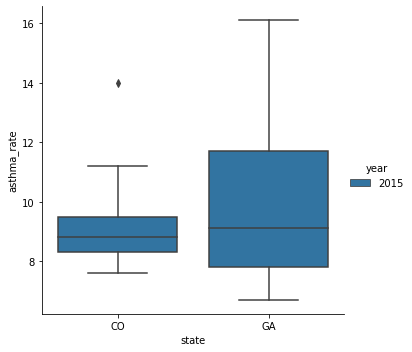

In [9]:
sns.catplot(y="asthma_rate", x = "state",  hue="year", kind="box" ,data=df[df.asthma_rate.notnull()])

#### Observations:

1. From this above plot, we see that the data for the asthma percentage has only been available for the year of 2015 and is null for the rest of the years. Here, we can make an assumption that the data might not have been collected for the 2013, 2014 and 2016, or was not available. 

2. We can also see that the percentage of population suffering from asthma is very high in Georgia as compared to Colorado and the distribution is a wider as well. Thus, we can assume this feature could play an important role in understanding the target variable.

3. This feature, in spite of having 83% nulls, c usean be useful in understanding the trends, **so instead of dropping this column, we would go ahead and create a new column** that will account for the cencus tracts(rows) where there is a value and for the rows with NaNs as well. We can represent the row with nulls as 0 and the rows with a value as 1.

### d. Creating new column for asthama rate for nulls

In [10]:
df['asthma_data_available'] = df['asthma_rate'].notnull()*1
df[df['year']==2015].tail(3)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_rate,asthma_data_available
1464,13121011900,"Census Tract 119, Fulton County, Georgia",2015,GA,0.894,0.038,0.535,0.044,0.961905,0.035,0.406,4.450357,NaN,NaN,NaN,10.7,1
1465,13121012000,"Census Tract 120, Fulton County, Georgia",2015,GA,0.761,0.036,0.898,0.019,0.649066,0.060,0.506,4.244475,2499.92,1129.77,1379.40,13.0,1
1466,13121012300,"Census Tract 123, Fulton County, Georgia",2015,GA,0.595,0.000,0.478,0.085,0.466714,0.073,0.100,4.755204,1411.73,861.46,517.59,NaN,0


#### Observations:

1. From the above table (where we printed only the last three rows from year 2015 since only this year had a combination of nulls and non null values)we can see that each row with a non null value is represented by 1 and the rows with nulls are represented by 0  

Now that we have created a new column for 'asthma_rate', we should drop the original column from the data to remove the ***multicollinearity***.

# 3.2 Data Processing: 

## Dropping columns that do not contribute to the model

1. Asthma rate ('asthma_rate') 

In [11]:
df.drop('asthma_rate', axis = 1, inplace=True)
df.head(2)

,id2,geography,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_data_available
0,8031000102,"Census Tract 1.02, Denver County, Colorado",2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,0
1,8031000201,"Census Tract 2.01, Denver County, Colorado",2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,0


### 2. Id ('id2') and Geography ('geography')

Id column is a unique value which does not contain any useful information. We **drop** the **id2** column along with the **georgraphy** column. 

In [12]:
df.drop(['id2', 'geography'], axis = 1, inplace=True)
df.head(2)

,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_data_available
0,2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,0
1,2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,0


## Filling all 'NaN' with mean

Missing values have known to be the factors that can essentially ensure the robustness of the model and also ensuring no bias has been introduced into the model by eliminating these missing values. Thus, it is very important to impute the rows and columns with appropriate values before feeding the data into a model to make predictions. Also, many models do not accept if the features have any missing values. 

There is no one right way of handling missing values or imputing the data. Different problems need different approaches. 

For eg: 

1. Simplest and fastest way is to use the **mean, median or mode** method. 

2. If we were treating this model as a time series model, we could have used **Last Observation carried forward(LOCF) or Next Observation carried backward approach (NOCB) or linear interpolation or seasonal adjustment + linear interpolation*** to impute the data.

3. If we had too many missing values, we could have used **linear regression by checking the correlation with other independent variables** to impute this data

4. If it were **categorical columns, we could have used statistical methods like ANOVA** or etc. for imputing the data.

5. Or we could use **KNN** for finding the nearest data points and assign a similar value.


**Since there aren't a lot of missing values in our case, we can use the mean value of each column to impute the null values in that column because the mean value does not change the distribution of the dataset, hence when we use mean, we are ensuring that I am not changing my distribution in this case**.

In [13]:
df = df.fillna(df.mean())
df.head(2)

,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_data_available
0,2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,0
1,2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,0


## Creating Target Variable

Finally, we have reached to a point where we cleaned the data, imputed all the missing values and now we are ready to create the target variable.

As we see, the energy burden column does not exist in the dataset which is our target variable. Hence we would be creating the variable from the equaltion mnetioned to us. 

Using the formula given to us in the question, we can create a new column for the target variable.

**energy burden = total  energy  bill  (avg  cost  of  elec  +  avg  cost of  gas)  divided  by  the  median  income.**

In [14]:
df['energy_burden'] = (df['avg_cost_electricity'] + df['avg_cost_gas'])/df['median_income']
df.head(2)

,year,state,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_electricity,avg_cost_gas,avg_cost_water,asthma_data_available,energy_burden
0,2013,CO,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,1164.00,516.00,219.24,0,348.560719
1,2013,CO,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,1794.08,864.16,393.18,0,561.783155


# 4. Data Analysis and Visualization 
This section focuses on understanding each variable and their impact on the target varible. Let us first start by understanding the target variable.

## 4.1 Energy Burden (Target variable)
Here, we would explore the target variable to understand it's distribution and the variance (if any)

In [15]:
df['energy_burden'].describe()

count    1956.000000
mean      556.468315
std       203.477768
min        79.953722
25%       422.343899
50%       550.123004
75%       653.249846
max      1779.474253
Name: energy_burden, dtype: float64

Here we can see that the min energy bill is 79 dollars and the max is 1779 dollars. This seems to be a very big distribution

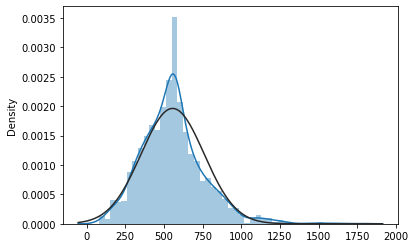

In [16]:
#histogram
sns.distplot(x = df['energy_burden'], kde= True, fit = norm)

#### Observations:

From the above distribution plot, we can see that the target variable:
1. Deviates a little from the normal distribution
2. Skewed towards the right
3. Has a visible peak

Let us now check for the amount of **skewness** and **kurtosis**

**Skewness** is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. Since our target variable has a slight skewness towards the right, I would be checking for this value.
- If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
- If the skewness is between -1 and — 0.5 or between 0.5 and 1, the data are moderately skewed
- If the skewness is less than -1 or greater than 1, the data are highly skewed


**Kurtosis** is a measure of whether the data distribution is heavy-tailed or light-tailed relative to a normal distribution. Data sets with *high kurtosis* tend to have *heavy tails, or outliers*. Data sets with *low kurtosis* tend to have *light tails, or lack of outliers*.

- If the distribution is tall and thin it is called a *leptokurtic distribution(Kurtosis > 3)*. Values in a leptokurtic distribution are near the mean or at the extremes.
- A flat distribution where the values are moderately spread out (i.e., unlike leptokurtic) is called *platykurtic(Kurtosis <3) distribution*.
- A distribution whose shape is in between a leptokurtic distribution and a platykurtic distribution is called a *mesokurtic(Kurtosis=3) distribution*. A mesokurtic distribution looks more close to a normal distribution.

In [17]:
#skewness and kurtosis
print("Skewness: %f" % df['energy_burden'].skew())
print("Kurtosis: %f" % df['energy_burden'].kurt())

Skewness: 0.864855
Kurtosis: 2.301507


#### Observations:

1. Here, we can see that the skewness is between 0.5 and 1.0 (positive), which means the data is **moderately skewed** and since the kurtosis is <3, the values are moderately spread out(**platykurtic distribution**) without too many outliers.

## 4.2 Correlation <a class="anchor" id="Correlation"></a>

We use a correlation map to understand the:
1. Relation between independent features and the dependent(target) feature
2. Relation amongst the independent variables to identify **multicollinearity**

We would be using this correlation matrix to perform feature selection. 

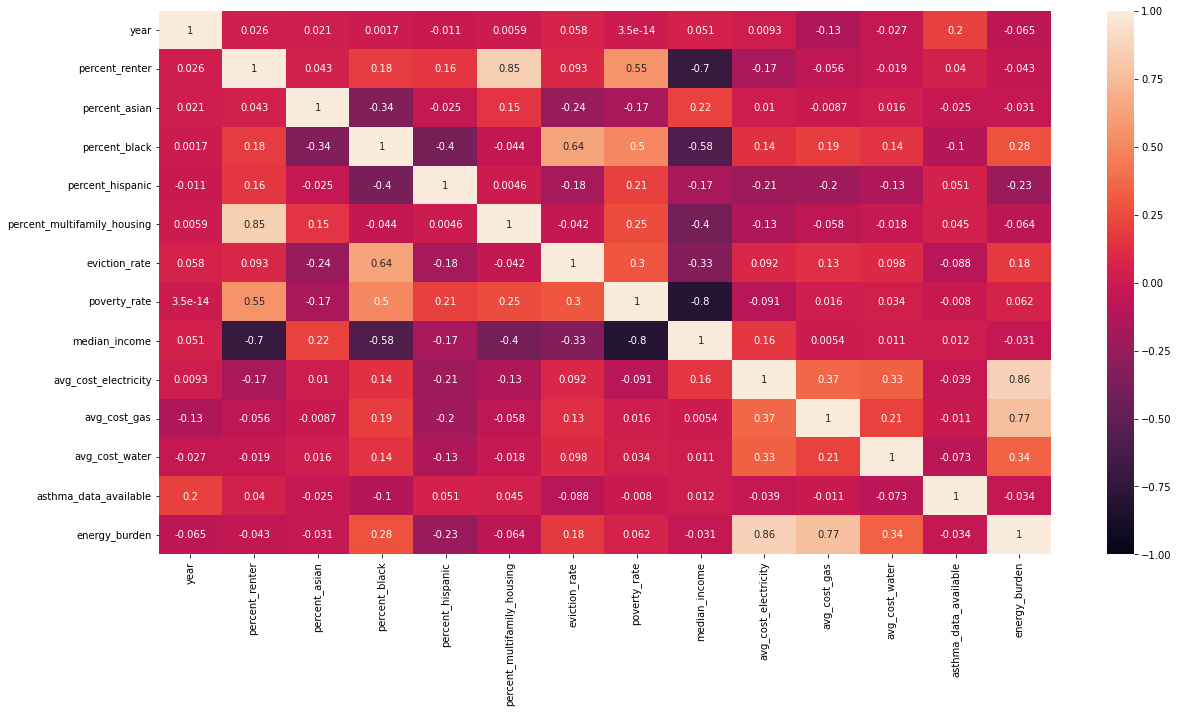

In [18]:
#Plotting the correlation

plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(method='pearson'), vmin=-1, annot=True)

#### Observations:

This correlation matrix helps us understand and observe the following:

**1. Correlation with target variable**: 
    
   a. Positive correlation: The correlation matrix shows that "avg_cost_electricity" and "avg_cost_gas" have a strong positive correlation with the target variable 'energy_burden' (because it is derived from these two features) followed by "avg_cost_water", "percent_black" and "eviction_rate".
    
   b. There is no strong negative correlation with any of the variables, but shows a slight negative relation with 'percent_hispanic' as conpared to the other variables.

**2. Multi-collinearity exists**: 
    
   a. 'median income' shows strong negative correlation with 'poverty rate' (justified as medium income would be less if the poverty rate is high and vice-versa), 'percent renter' and 'percent black'. It shows a slight positive correlation with 'percent_asians' and 'avg cost electricity'.
    
    
#### My take on these observations:
    
   a. As the average cost of electricity, gas and water increases, the energy burden also increases. We can also say that in regions where more population of African Americans exist, the energy burden is high. 

   b. Census tract with higher asian populations make higher median incomes and spend high on the avg electricity cost. Whereas areas with high African-american population have lesser median income.

## 4.3 Data Leakage

**Data leakage** occurs when the data used in training process contains information about what the model is trying to predict. Data leakage is a serious and widespread problem in data mining and machine learning which needs to be handled well to obtain a robust and generalized predictive model. 

In this case, our target variable "energy burden" is a function of existing independent variables ("average cost of electricity, gas and the median income). Thus, the model learns the direct strong correlation between these variables. **If we already know that the electricity and gas bill is high in a cencus tract, we may not even need a predictive model to start with. Because we can directly infer from the data that if the avg cost of electricity or gas is high, then the energy burden will automatically be high**.

Thus it is very important to eliminate these features from the model. So, in this step, we would be **dropping the avg cost of electricity and gas columns**. Since median income does not show a very high correlation with the target variable, we can retain it instead of dropping.

Once we drop these columns, we can plot the correlation matrix again and pick the top 10 features that have a strong relation with the target variable.


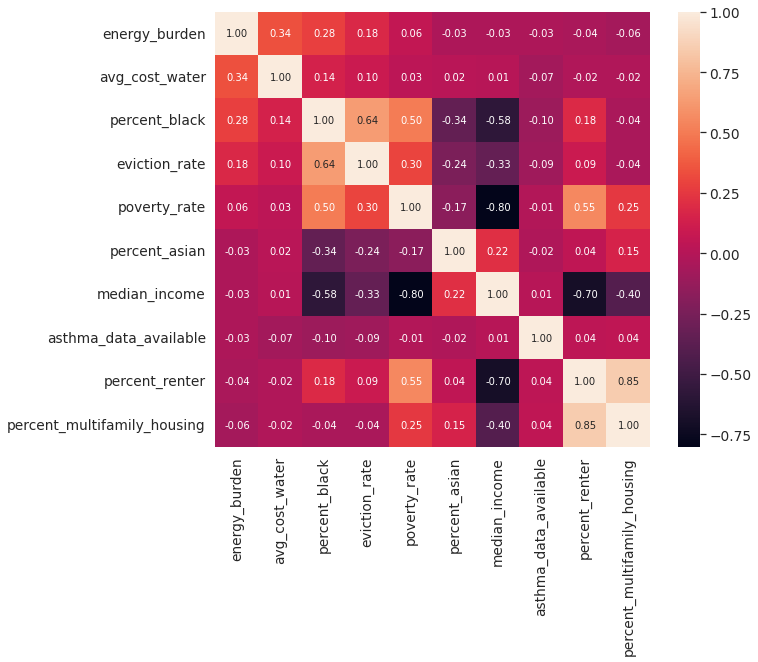

In [19]:
df = df.drop(['avg_cost_electricity', 'avg_cost_gas'], axis = 1)

#Looking at the top 10 features that have an impact on our target variable 

k = 10 #number of variables for heatmap
top_cols = df.corr().nlargest(k, 'energy_burden')['energy_burden'].index
cm = np.corrcoef(df[top_cols].values.T)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=top_cols.values, xticklabels=top_cols.values)
plt.show()

#### Observations:

1. From this graph, we can pick top 10 fearures that have an impact on the target variable (energy burden).
2. There are still independent features which show strong multicollinearity with each other. We would be addressing this issue in the coming sections.

## 4.3 Relationship with Variables

In this section, I try to dig deeper into the impact of geaographical trends and yearly trends. I also analyse data distribution of individual features using univariate analysis and impact of each feature with the target variable using multivariate analysis.

### 4.3.1 Geographical Trends

Since the data is of two different states, one Colorado is a more colder state as conpared to Georgia, I believe the energy expenses would be very different. Here, I am analysing the trends depending on each state across the data of 4 years. I am plotting a kernel density plot for understand the continuous distrubution.

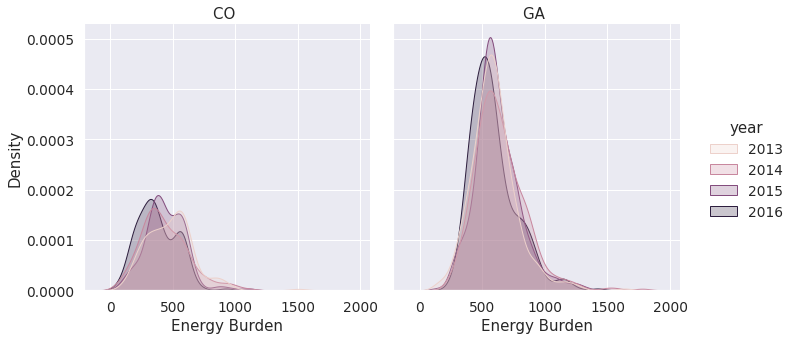

In [20]:
#histogram representations depending on the city

g = sns.displot(
    data=df, x='energy_burden', hue="year", col="state", kind = 'kde', fill=True)
g.set_axis_labels("Energy Burden")
g.set_titles("{col_name} ")

#### Observations: 

1. From the above plots, we can clearly see a great distiction between the energy burden of the two states. 
2. It is also evident that each state's energy burden varies slightly over the years.

To understand what features have a major impact in a specific state, we would be digging a little deeper.

### 4.3.2 Correlation of target variable with Colorado and Georgia

#### Colorado

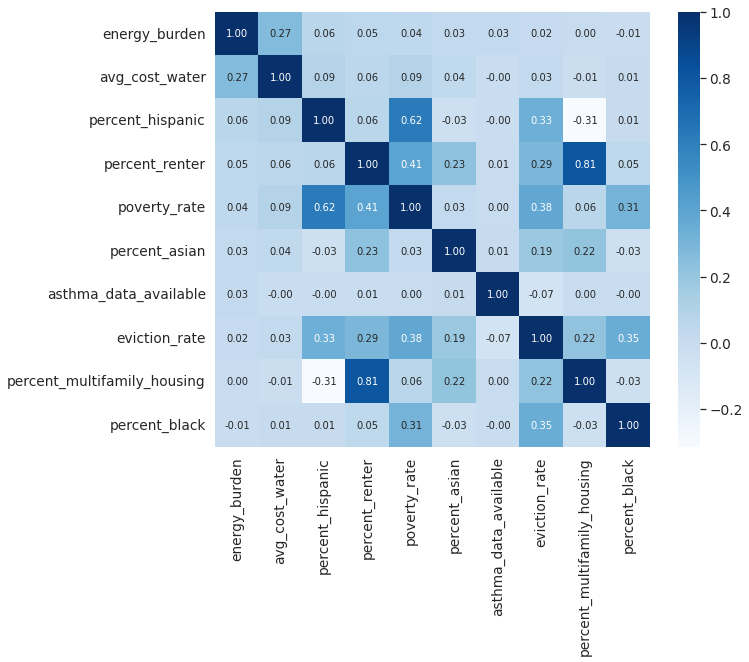

In [21]:
df_co = df[df['state'] == 'CO']
X = df_co.drop(['energy_burden', 'state'], axis=1)
y = df_co['energy_burden'] 

k = 10 #number of variables for heatmap
top_cols_co = df_co.corr().nlargest(k, 'energy_burden')['energy_burden'].index
cm = np.corrcoef(df_co[top_cols_co].values.T)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap = 'Blues', yticklabels=top_cols_co.values, xticklabels=top_cols_co.values)
plt.show()

#### Observations:

1. Moderately positive correlation exists between **avg cost of water**.
2. Unlike in the above correlation plot while taking in all the observations and saw that percent of black/african americans has a slight positive correlation with the target variable, but here, considering census tracts only in Colorado, the % of black/african americans does not have a major impact on the target variable.


#### Georgia

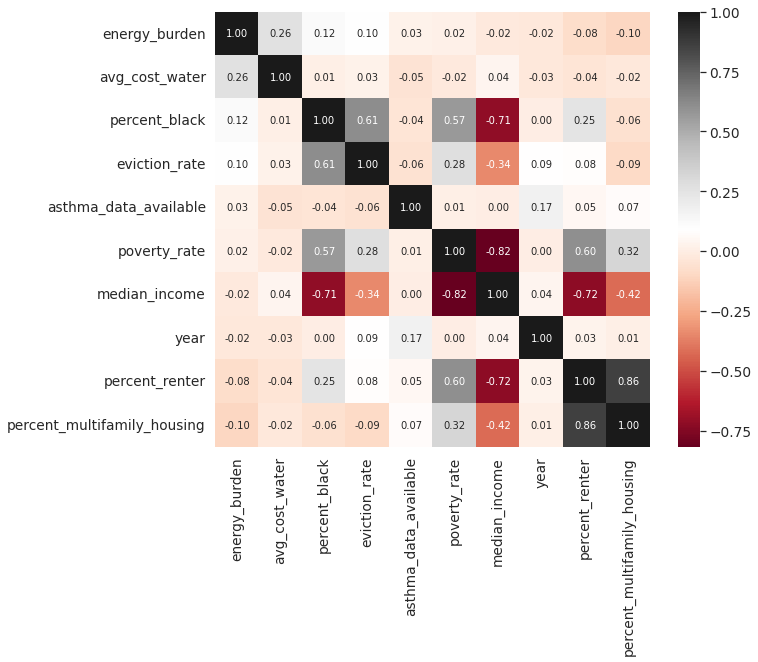

In [22]:
df_ga = df[df['state'] == 'GA']
X = df_ga.drop(['energy_burden', 'state'], axis=1)
y = df_ga['energy_burden'] 

k = 10 #number of variables for heatmap
top_cols_ga = df_ga.corr().nlargest(k, 'energy_burden')['energy_burden'].index
cm = np.corrcoef(df_ga[top_cols_ga].values.T)
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, cmap = 'RdGy', yticklabels=top_cols_ga.values, xticklabels=top_cols_ga.values)
plt.show()

#### Observation:

1. Moderately positive and negative correlation with **cost of water, eviction_rate** and **percentage of blacks** respectively.
2. In Georgia, unlike in Colorado, we can say that areas with hight population of african americans, ther energy_burden is high.


Since the features that have a huge impact on the target variable are the same in almost all the above correlation matrices, we can choose the top 10 features and eliminate the multicollinearity before working on the model.

## 4.4 Creating Dummy Variables for categorical columns

In [23]:
df = pd.get_dummies(df, columns=['year', 'state'], drop_first=True)
df.head(2)

,percent_renter,percent_asian,percent_black,percent_hispanic,percent_multifamily_housing,eviction_rate,poverty_rate,median_income,avg_cost_water,asthma_data_available,energy_burden,year_2014,year_2015,year_2016,state_GA
0,0.303,0.000,0.011,0.237,0.179503,0.006,0.048,4.81982,219.24,0,348.560719,0,0,0,0
1,0.207,0.011,0.009,0.608,0.059393,0.015,0.090,4.73179,393.18,0,561.783155,0,0,0,0


## 4.5. Understanding multicollinearity

**Multicollinearity** exists when one or more **independent variables are highly correlated with each other**. This is a violation of one of the assumptions that must be met in multiple linear regression problems. This also affects the standard error of the regression coefficient. This poses a problem when the correlation between variables becomes higher. As the degree of collinearity increases, so does the size and volatility of the regression coefficient. 

We can check for **multicollinearity using variance inflation factor (VIF)**. Here, the dependent variable is removed from the picture and each independent variable is regressed against all other independent variables. The resultant R² value is used to represent VIF mathematically as shown in the following equation:
                    ***VIF = 1/(1-R²)***

**How to interpret?**

1. A value of 1 indicates that there is no correlation between this independent variable and any others. 

2. Some studies believe that a VIF value between 1 to 5 suggests moderately correlated and the values >5 are critical and need to be dropped.

3. Other studies suggest that values >10 are critical and need to be dropped.


**In this model:** Here, we would use the latter study as a reference and try to drop features with high VIF values till all the featues reach to a value below 10 since I do not have too many features and capping it at 5 would mean we could lose too many features.

In [24]:
#Calculating Multicollinearity using VIF
# For each X in the top 10 features, calculate VIF and save in dataframe
df_coll = df[top_cols]
df_coll = df_coll.drop(['energy_burden'], axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_coll.values, i) for i in range(df_coll.shape[1])]
vif["features"] = df_coll.columns
vif.round(1)

,VIF Factor,features
0,4.4,avg_cost_water
1,4.7,percent_black
2,2.9,eviction_rate
3,5.0,poverty_rate
4,1.8,percent_asian
5,9.2,median_income
6,1.2,asthma_data_available
7,32.6,percent_renter
8,14.5,percent_multifamily_housing


In [25]:
# We can see multicollinearity in the data, let us try dropping the one with highest VIF value

df_coll = df_coll.drop('percent_renter', axis = 1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(df_coll.values, i) for i in range(df_coll.shape[1])]
vif["features"] = df_coll.columns
vif.round(1)

,VIF Factor,features
0,4.4,avg_cost_water
1,4.6,percent_black
2,2.9,eviction_rate
3,3.3,poverty_rate
4,1.8,percent_asian
5,7.4,median_income
6,1.2,asthma_data_available
7,3.4,percent_multifamily_housing


#### Observations:

1. After Dropping the renter percentage, I finally have a list of features that complies with the acceptable range of the VIF values. Thus, here we have ensured that the independent features are not dependent on each other, thus creating exogenous indicators. 

## 4.5 Shuffling data to introduce ramdonmness
Since we are no longer treating it as a time series data, we can shuffle the dataset to introduce randomness so that the models do not memorize the data and predictions, but rather use a stochastic approach in learning to be able to predict unseen data in a better way.


In [26]:
df_top_cols = df[top_cols].drop('percent_renter', axis = 1)
df_shuffled=sklearn.utils.shuffle(df_top_cols)
df_shuffled.head(5)

,energy_burden,avg_cost_water,percent_black,eviction_rate,poverty_rate,percent_asian,median_income,asthma_data_available,percent_multifamily_housing
1598,633.441585,939.50,0.307,0.024,0.053,0.056,4.840225,0,0.000000
1758,541.971827,653.22,0.678,0.034,0.076,0.011,4.843370,0,0.123188
399,772.578986,1200.83,0.093,0.004,0.006,0.023,5.172714,0,0.516630
538,460.590049,469.07,0.017,0.012,0.010,0.021,4.812913,0,0.297903
982,315.677055,468.59,0.069,0.011,0.062,0.000,4.918476,1,0.171601


#### Observations:

1. From the above table we can notice that the data is randomly well shuffled and the purpose of introducing randomness has been achieved. 

## 4.6. Univariate Analysis and Multivariate Analysis

Visual analysis is helpful in understand the features and relation with the target variable. In this section we work at visually presenting the features for easy understanding.

Univariate analysis is where we are analyzing one feature at a time to understand its distribution and outliers

### 4.6.1 Univariate  analysis - Box Plot
A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”).
It can tell you about your outliers and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

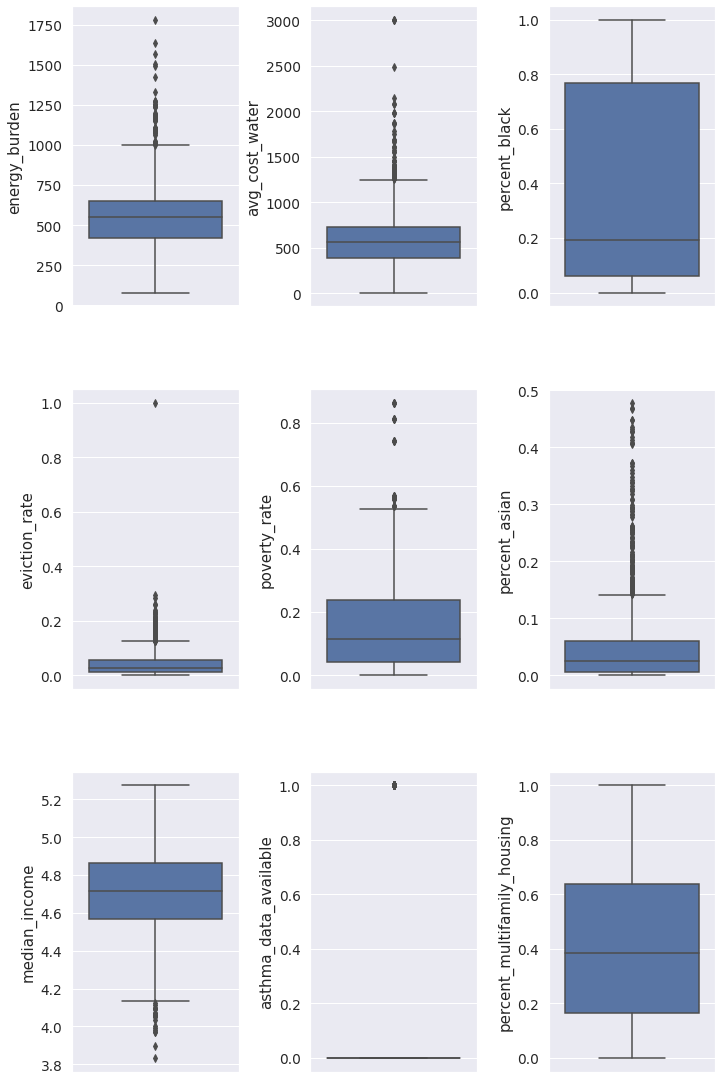

In [27]:
#Plotting the distributions to visually inspect the spread or each feature and the outliers in each column

#Box plot fpr understanding their spread and outliers
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(10, 15))
index = 0
data = df_shuffled.columns
axs = axs.flatten()
for k,v in df_shuffled.items():
    sns.boxplot(y=k, data=df_shuffled, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

#### Observations:

1. From these above box plots, we can see the data distribution of each feature and the outliers. 

### 4.6.2 Univariate Analaysis - Distribution Plot

Distrubition plots helps me uin understanding the kurtosis or peakedness of the data.

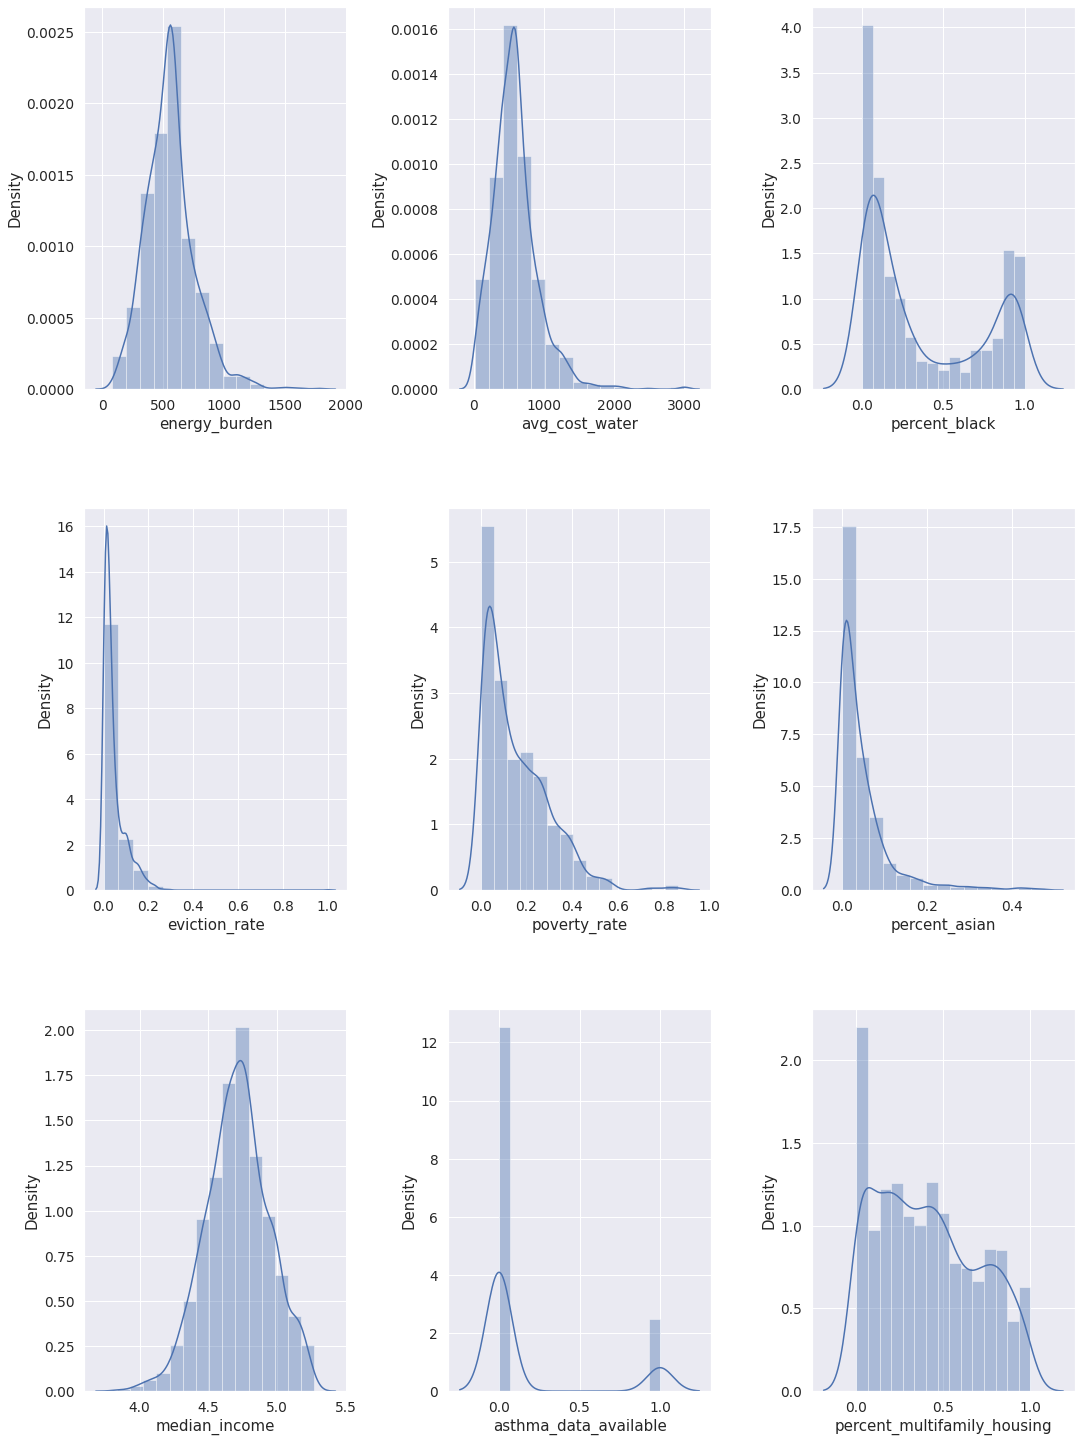

In [28]:
#Distplot for looking at the distribution (univariate distribution)

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15, 20))
index = 0
axs = axs.flatten()
for k,v in df_shuffled.items():
    sns.distplot(v, ax=axs[index], bins = 15)
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

#### Observations:
From the above plots, we can see that most of the features are skewed towards the right. Some show very prominenet peakedness and the others show multiple peaks.

### 4.6.3 Multivariate Analysis - Scatter Plot

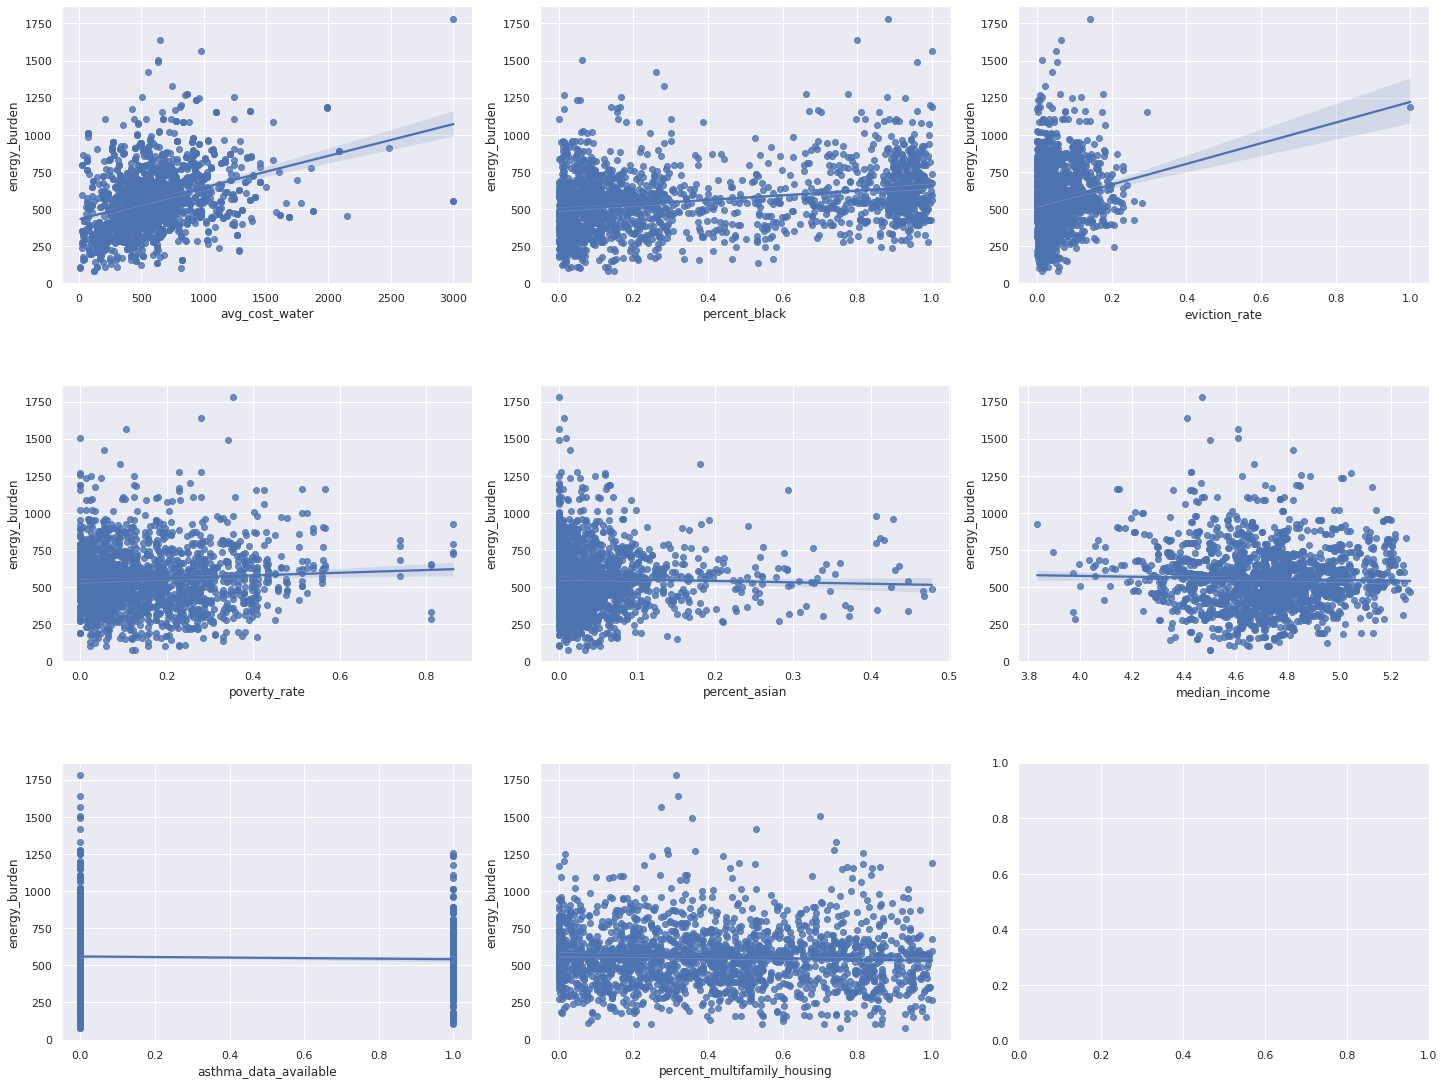

In [29]:
#Picking columns which have a correlation above 0.3
sns.set_theme(color_codes=True)

#X = df_shuffled.drop(['energy_burden', 'avg_cost_electricity', 'avg_cost_gas'], axis=1)
X = df_shuffled.drop(['energy_burden'], axis=1)
y = df_shuffled['energy_burden'] 
column_sels = X.columns

#x = pd.DataFrame(data=min_max_scaler.fit_transform(X), columns=column_sels)
x = pd.DataFrame(data = X, columns=column_sels)
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 15))
index = 0
axs = axs.flatten()
for i, k in enumerate(column_sels):
    sns.regplot(y=y, x=x[k], ax=axs[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

# 5. Feature Scaling and Statistical Significance

## 5.1 Normalize Skewed Data

In order to account for the skewedness and handle the outliers, we would be taking the log of the columns with skew value > 0.3. This will ensure the data is transformed to a normal distribution.

In [30]:
y =  np.log1p(y)

for col in X.columns:
    if np.abs(X[col].skew()) > 0.3:
        X[col] = np.log1p(X[col])
    

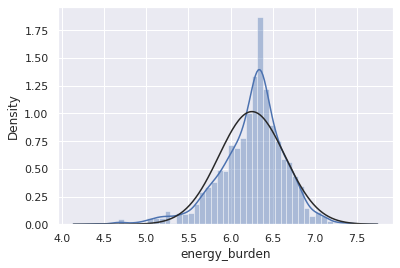

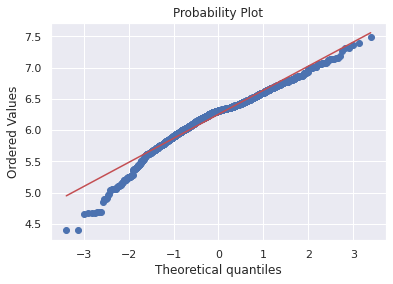

In [31]:
#transformed histogram and normal probability plot

sns.distplot(y, kde = True, fit = norm);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

#### Observation:

This above plot shows that after trnsformation, the target variable looks like it is close to having a normal distribution.

## 5.2 Statistical significance of independent variables

In [32]:
#ols model 
import statsmodels.api as sm

X = sm.add_constant(X)
ols_model = sm.OLS(y, X)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          energy_burden   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     70.20
Date:                Tue, 30 Aug 2022   Prob (F-statistic):          1.25e-101
Time:                        15:00:53   Log-Likelihood:                -697.50
No. Observations:                1956   AIC:                             1413.
Df Residuals:                    1947   BIC:                             1463.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           3.2137      0.349      9.199      0.000       2.529       3.899
avg_cost_water                  0.1870      0.012     15.860      0.000       0.164       0.210
percent_black                   0.6020      0.051     11.750      0.000       0.502       0.703
eviction_rate                  -0.2153      0.225     -0.956      0.339      -0.657       0.227
poverty_rate                    0.0999      0.119      0.838      0.402      -0.134       0.334
percent_asian                   0.3794      0.147      2.577      0.010       0.091       0.668
median_income                   0.3557      0.070      5.105      0.000       0.219       0.492
asthma_data_available           0.0499      0.031      1.619      0.106      -0.011       0.110
percent_multifamily_housing     0.0261      0.047      0.558      0.577      -0.066       0.118
==============================================================================
Omnibus:                      116.144   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.662
Skew:                          -0.422   Prob(JB):                     1.21e-48
Kurtosis:                       4.413   Cond. No.                         370.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
X = X.drop(['poverty_rate', 'eviction_rate', 'asthma_data_available', 'percent_multifamily_housing'], axis = 1)
X = sm.add_constant(X)
ols_model = sm.OLS(y, X)
result = ols_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          energy_burden   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     139.2
Date:                Tue, 30 Aug 2022   Prob (F-statistic):          9.26e-105
Time:                        15:00:53   Log-Likelihood:                -699.80
No. Observations:                1956   AIC:                             1410.
Df Residuals:                    1951   BIC:                             1437.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.5207      0.207     17.043      0.000       3.116       3.926
avg_cost_water     0.1865      0.012     15.872      0.000       0.163       0.210
percent_black      0.5630      0.041     13.841      0.000       0.483       0.643
percent_asian      0.3907      0.144      2.719      0.007       0.109       0.672
median_income      0.2974      0.042      7.084      0.000       0.215       0.380
==============================================================================
Omnibus:                      116.302   Durbin-Watson:                   1.938
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              220.272
Skew:                          -0.423   Prob(JB):                     1.47e-48
Kurtosis:                       4.409   Cond. No.                         213.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Observations:
In statistical hypothesis testing, the p-value or probability value is, for a given statistical model, the probability that, when the null hypothesis is true, the statistical summary (such as the absolute value of the sample mean difference between two compared groups) would be greater than or equal to the actual observed results.

The lower the p-value, the better we are at rejecting the null hypothesis and proving a feature has a significant impact on the target variable. The threshold is <0.05. So from the above table, we can dropp the features that have a p-value of > 0.05. Thus we are left with features that have helped us in rejecting the null hypothesis and accepting the alternate hypothesis that these is a relation between these independent variables and the target variable.


# 6. Model Building

Since we are build a regression model, the metrics used to evaluate the model are:
1. **Residual plots** - Residual plots show the residual values on the y-axis and predicted values on the x-axis. Residual plot showing the errors corresponding to the predicted values must be randomly distributed. Here we are checking for signs of a systematic pattern to underdstand if the model is biased.

2. **Mean Squared Error (MSE)**: It is used to measure the average of the squared difference between the predicted and actual value. Since it is differentiable and has a convex shape, it is easier to optimize. 

P.S  *Mean absolute error* is another metric that can be used as well, but it does not work well with outliers as it is unable to penalize them. Since this data has significant outliers, we would be using *mean squared error* as a metric.

3. **R-squared or Coefficient of Determination** : R2 represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between the model and the dependent variable. Closer the R2 value to 1.0, better the model at explaining the variannce around its mean.

## 6.1 Creating train, validation and test datasets

In [34]:
# Step 1. Splitting train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=5)

# Step 2. Split the train data into train and validate dataset

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state = 5)
X_train.drop('const', axis = 1, inplace = True)
X_val.drop('const', axis = 1, inplace = True)
X_test.drop('const', axis = 1, inplace = True)

print('X_train shape: {} , y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_val shape: {} , y_val shape: {}'.format(X_val.shape, y_val.shape))
print('X_test shape: {} , y_test shape: {}'.format(X_test.shape, y_test.shape))


X_train shape: (1412, 4) , y_train shape: (1412,)
X_val shape: (250, 4) , y_val shape: (250,)
X_test shape: (294, 4) , y_test shape: (294,)


## 6.2. Building baseline models

It is very diffucult to choose the best model in the very first attempt without trying diffrent options. Hence, we are creating a baseline model using a simple linear regression model since the assumptions of the linear regression model have been satisfied.

### 6.2.1 Model 1: Linear Regression

Linear regression is an analysis that assesses whether one or more predictor variables explain the dependent (criterion) variable

**The Four Assumptions of Linear Regression:**

1. Linear relationship: There exists a linear relationship between the independent variable, x, and the dependent variable, y.
2. Independence: The residuals are independent.
3. Homoscedasticity: The residuals have constant variance at every level of x.
4. Normality: The residuals of the model are normally distributed.

From the above analysis and featurte engineering, we can see that this data complies with each assumption of the model and hence can be used in a linear regression model.



In [35]:
#Basemodel: LINEAR REGRESSION
basemodel = LinearRegression()

#Fitting the model
basemodel.fit(X_train, y_train)

#Evaluating
y_train_pred = basemodel.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("\nThe model performance on training data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))


The model performance on training data
--------------------------------------
RMSE is 0.350094730309691
R2 score is 0.22498682904759537


#### Observations:
1. Measuring the performance of the training model, the model has 0.3 RMSE and only 0.22 R2 value. This means the model is only able explain only 22% of the variance around its mean and the error is around 34%. 

#### Regularizing the model:
Regularization is a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting. We would be using this to ensure we are penalizing the coefficients correctly to avoid hig variance on my test data.

We can create two regularized linear regression models
1. Ridge regression: Ridge regression is also called L2 regularization. It adds a constraint that is a linear function of the squared coefficients. It penalizes the coefficients to almlost zero (but not actual zero). This ensured there is n o loss of features.
2. Lasso Regression: Lasso is also known as L1 regularization. It penalizes the model by the absolute weight coefficients and forces some coefficients to become zero. It is also used in feature selection because of this property. 



Least RMSE Value:  0.3520261930675811


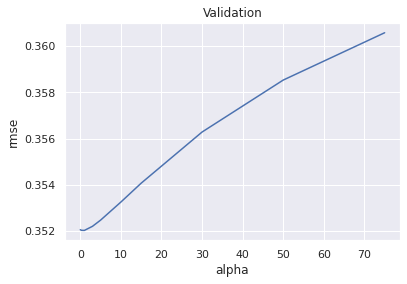

In [36]:
#Regilarization

from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

#Ridge Regression
model_ridge = Ridge()
alphas = [ 0.0001, 0.001, 0.003, 0.005, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

print('Least RMSE Value: ', cv_ridge.min())


Mean RMSE Value:  0.3522875474143634
Lasso picked 4 variables and eliminated the other 0 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

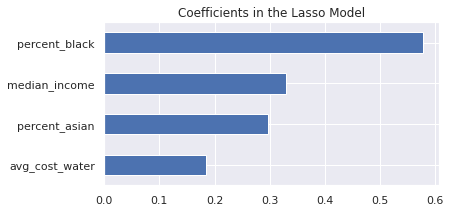

In [37]:
#Lasso Regression

model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y_train)
print('Mean RMSE Value: ', rmse_cv(model_lasso).mean())

#Checking if any feature coefficients were penalized to an absolute 0
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

#Visualizing the features
imp_coef = pd.concat([coef.sort_values().head(6)])
plt.rcParams['figure.figsize'] = (6.0, 3.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")


#### Observations:
1. From the ridge regression we can see that the rmse value increases when the alpha value increases. Thus the lower the value of alpha, better the model's performance.
2. From the Lasso regression we can see that no coefficients were penalized to make tham an absolute zero. 

In both the cases the rmse value is around 0.34, similar to what we got from our baseline model. Thus, we could go ahead and use the baseline model and cross validate the model using 10 fold cross validation.

#### Cross-validation:

In [38]:
# Cross validation - checking for R-squared values

num_folds = 10
seed = 7

folds = KFold(n_splits = num_folds, shuffle = True, random_state = 42)
scores = cross_val_score(basemodel, X_train, y_train, scoring='r2', cv=folds, verbose=1)
r2= '{:.2f}'.format(scores.mean()*100)
print("\nScores for all 10 folds:\n", scores)
print('\nAverage R2 score: ', scores.mean())
print('\nThe model explains {}% of the variability of the response data around its mean'.format(r2))


Scores for all 10 folds:
 [0.1878264  0.22380704 0.21676955 0.2264015  0.16765048 0.21376086
 0.24726014 0.21337977 0.16504561 0.26698753]

Average R2 score:  0.21288888966191127

The model explains 21.29% of the variability of the response data around its mean


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


#### Observations:
1. Here we are measuring for the R-squared value. The higher the r2 value, better the model is at explaining the variance around its mean. In this case, the model just explains 21.1% variability of the response data.

#### Evaluation on Validation Data:

In [39]:
# model evaluation for validation set
y_val_pred = basemodel.predict(X_val)
rmse = (np.sqrt(mean_squared_error(y_val, y_val_pred)))
r2 = r2_score(y_val, y_val_pred)

print("\nThe model performance on validation data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

rmse = (np.sqrt(mean_squared_error(y_val, y_val_pred)))
r2 = r2_score(y_val, y_val_pred)
print('\nRMSE score is: {} and R2 is {} on the validation data'.format(rmse, r2))


The model performance on validation data
--------------------------------------
RMSE is 0.3367284238390533
R2 score is 0.24004448684660018

RMSE score is: 0.3367284238390533 and R2 is 0.24004448684660018 on the validation data


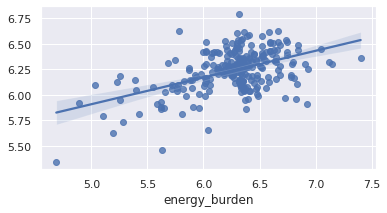

In [40]:
sns.regplot(y_val, y_val_pred)

#### Observbations: 
1. The basemodel is able to explain only 22% variability of the response data around its mean which is a very poor result.

### 6.2.2 Model 2: Random Forest regressor:

Random forests are bagged decision tree models that split on a subset of features on each split. It is known to be robust at handling outliers and also penalizing the coefficients while regularizing the model. Hence, we choos the random forest regressor model as my second option

In [41]:
#random forest

rand_model = RandomForestRegressor(n_estimators = 5)
rand_model.fit(X_train, y_train)

#Evaluating on training data
y_train_pred = rand_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("\nThe model performance on training data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rand_model.get_params())


The model performance on training data
--------------------------------------
RMSE is 0.1619510084665381
R2 score is 0.8341539053803072
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


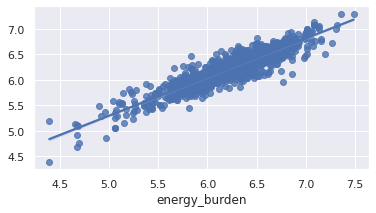

In [42]:
sns.regplot(y_train, y_train_pred)

#### Hyperparameter tuning

In [43]:
#Improving the randomforest model using gridsearchcv

n_estimators = [int(x) for x in np.arange(start = 1, stop = 10, step = 1)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Fit the random search model
rand_model = RandomizedSearchCV(estimator = rand_model, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)
rand_model.fit(X_train, y_train)

#Evaluating on training data
y_train_pred = rand_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("\nThe model performance on training data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}\n'.format(r2))

rand_model.best_params_


The model performance on training data
--------------------------------------
RMSE is 0.24912650777180181
R2 score is 0.6075558893731898



{'n_estimators': 9,
 'min_samples_leaf': 4,
 'max_features': 0.5,
 'bootstrap': True}

In [44]:
rand_model = RandomForestRegressor(n_estimators = 5, min_samples_leaf = 2, max_features = 0.5, bootstrap = True )
rand_model.fit(X_train, y_train)

#Evaluating on training data
y_train_pred = rand_model.predict(X_train)
rmse = (np.sqrt(mean_squared_error(y_train, y_train_pred)))
r2 = r2_score(y_train, y_train_pred)

print("\nThe model performance on training data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))



The model performance on training data
--------------------------------------
RMSE is 0.20989146278305415
R2 score is 0.7214344001574896


#### Regularizing the model:

In [45]:
num_folds = 10

folds = KFold(n_splits = num_folds)
scores = cross_val_score(rand_model, X_train, y_train, scoring='r2', cv=folds, verbose=0)
r2= '{:.2f}'.format(scores.mean()*100)
print("\nScores for all 10 folds:\n", scores)
print('\nAverage R2 score: ', scores.mean())
print('\nThe model explains {}% of the variability of the response data around its mean'.format(r2))


Scores for all 10 folds:
 [0.14711309 0.23327843 0.12120676 0.22436939 0.17765296 0.29756594
 0.12620912 0.16990551 0.05658273 0.17908952]

Average R2 score:  0.17329734434408844

The model explains 17.33% of the variability of the response data around its mean


#### Evaluation on Validation dataset:

In [46]:
# model evaluation for validation set
y_val_pred = rand_model.predict(X_val)
rmse = (np.sqrt(mean_squared_error(y_val, y_val_pred)))
r2 = r2_score(y_val, y_val_pred)

print("\nThe model performance on validation data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

rmse = (np.sqrt(mean_squared_error(y_val, y_val_pred)))
r2 = r2_score(y_val, y_val_pred)
print('\nRMSE score is: {} and R2 is {} on the validation data'.format(rmse, r2))


The model performance on validation data
--------------------------------------
RMSE is 0.35497055389158655
R2 score is 0.15547351985174307

RMSE score is: 0.35497055389158655 and R2 is 0.15547351985174307 on the validation data


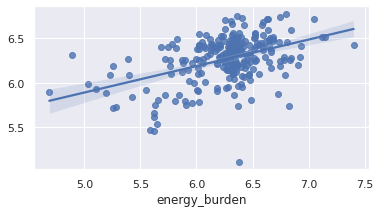

In [47]:
sns.regplot(y_val, y_val_pred)

#### Model Comparison

In [48]:
columns = ['Linear Regression','Random Forest Regressor']
rows = ['RMSE Scores', 'R2 scores']
r2 = [0.22328504167921615, 0.17023630346659846 ]
rmse = [0.351321348689609, 0.3631206287168931]
valuedf = pd.DataFrame([rmse, r2], rows, columns)
valuedf

,Linear Regression,Random Forest Regressor
RMSE Scores,0.351321,0.363121
R2 scores,0.223285,0.170236


#### Observation: 

Looking at the above comparison, we can say that the Linear regression performs better than the Random Forest regressor. Probably because Random forest regressor is overfitting due to very limited number of features.

## 6.3 Final Model

After carefully evaluating and cross validating the above two models, I belive the Linear regression model performs better as compared to the Random forest model. Thus, using this model on the test data.

In [49]:
y_test_pred = basemodel.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)
print("\nThe model performance on test data")
print("--------------------------------------")
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

print('\nRMSE score is: {} and R2 is {} on the test data'.format(rmse, r2))


The model performance on test data
--------------------------------------
RMSE is 0.3356992327540803
R2 score is 0.180417584200807

RMSE score is: 0.3356992327540803 and R2 is 0.180417584200807 on the test data


#### Observation: 

**From the above analysis we can see that the model explains only 19.6% of the variability around the data**. 

### 6.3.1 Saving model weights

In [50]:
import pickle
#Saving the model and testing by reloading it
pickle.dump(basemodel, open('linear_regression.pkl','wb'))
print("MODEL HAS BEEN SAVED SUCCESSFULLY")

# Loading model to compare the results
model = pickle.load(open('linear_regression.pkl','rb'))
pred = model.predict(X_test)
print("MODEL PREDICTION IS READY")

MODEL HAS BEEN SAVED SUCCESSFULLY
MODEL PREDICTION IS READY


# 7. Conclusion:

1. After this analysis, we can conclude that:
Ethnicity, income and cost of water play a major role in understanding the energy burden. 
Specifically, percentage of black/ african-american population, median income, percentage of asian population and avg cost of water are the four variables that I narrowed down to being the exogenous which have a correlation with the target variable.

2. Geographical location (state) plays a vital role in explaining the trends of energy consumption and burden. It is my intuition here that weather plays a very important factor in depfining the energy consumption. If given a chance, collecting this data would be pivotal in understanding the energy burden in a more robust fashion for a locality.

3. We could establish a pattern in the Ashthma rate when comparing the two states

3. Due to insufficiency in granularity of the data, the model was only able to explain 19% of the variability in the test data. Increasing the granularity to a monthly level would have helped us understand the seasonal consumption, increasing it to a hourly level, would help us in understanding the pattern of consumption for the above exogenous variables giving us a better understanding of the pattern between the energy consumption and the demographics.

4. Using the process of cross validation ( K-Fold cross validation) and regularization ( Ridge, Lasso and Grid search), we ensured the model would not overfit. It was confirmed again when the model could explain only 22.3% of the variance in the validation dataset.
